# Simulation study

In [10]:
import numpy as np
from scipy.stats import binom, norm, t
from methods import birge, random_effects_hksj, binomial_method
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# use tex
plt.rc("text", usetex=True)

## Table 1

In [ ]:
# | label: table-n-nb

p = 0.5
coverages_mu = []
target_coverage = 0.6827
tail_alpha = (1 - target_coverage) / 2

settings = [
    "random_effects",
    "birge",
    "random_effects_outliers",
    "adversarial",
    "random_effects_corr",
]


# ns = [3, 10, 31, 100, 316, 1000]
ns = np.logspace(0.5, 3, 6).astype(int)
tail_alphas = {}
target_coverages = {}
rows = []
for n in ns:
    ks = np.arange(0, n + 1)
    cdf = binom.cdf(ks, n, p)
    tail_alpha_achieved = cdf[np.argmax(np.array(cdf) >= tail_alpha) - 1]
    tail_alphas[n] = tail_alpha_achieved
    target_coverages[n] = 1 - 2 * tail_alpha_achieved
    z_score = norm.ppf(1 - tail_alpha_achieved)
    new_row = {
        "n": n,
        "target_coverage": np.round(target_coverages[n], 3),
        "tail_alpha": np.round(tail_alpha_achieved, 3),
        "z_score": np.round(z_score, 3),
    }
    rows.append(new_row)

table = pd.DataFrame(rows)
# set n column as index
table.set_index("n", inplace=True)
# print as markdown table
print(table.to_markdown())

|    n |   target_coverage |   tail_alpha |   z_score |
|-----:|------------------:|-------------:|----------:|
|    3 |             0.75  |        0.125 |     1.15  |
|   10 |             0.891 |        0.055 |     1.601 |
|   31 |             0.719 |        0.141 |     1.078 |
|  100 |             0.729 |        0.136 |     1.1   |
|  316 |             0.715 |        0.143 |     1.069 |
| 1000 |             0.703 |        0.148 |     1.044 |


## Simulation code

In [6]:
mus = np.logspace(-3, 3, 13)

results = {}
for i in range(len(settings)):
    setting = settings[i]
    results[setting] = {}
    total = len(ns) * len(mus)
    for n, mu in tqdm(itertools.product(ns, mus), total=total):
        results[setting][(n, mu)] = {}

        tail_alpha = tail_alphas[n]
        target_coverage = 1 - 2 * tail_alpha
        z_alpha = norm.ppf(1 - tail_alpha)
        t_alpha = t.ppf(1 - tail_alpha, n - 1)

        ks = np.arange(0, n + 1)
        cdf = binom.cdf(ks, n, p)

        coverages_nonoise = []
        lengths_nonoise = []

        coverages_re = []
        lengths_re = []

        coverages_birge = []
        lengths_birge = []

        for j in range(16000):
            if setting == "random_effects":
                systematic_errors = np.random.normal(0, mu, n)
                noise_magnitudes = np.random.exponential(1, n)
                random_errors = np.random.normal(0, noise_magnitudes, n)
                values = systematic_errors + random_errors
            elif setting == "birge":
                noise_magnitudes = np.random.exponential(1, n)
                random_errors = np.random.normal(0, noise_magnitudes, n)
                values = random_errors * mu
            elif setting == "random_effects_outliers":
                systematic_errors = np.random.standard_cauchy(n) * mu
                noise_magnitudes = np.random.exponential(1, n)
                random_errors = np.random.normal(0, noise_magnitudes, n)
                values = systematic_errors + random_errors
            elif setting == "adversarial":
                noise_magnitudes = np.random.exponential(1, n)
                random_errors = np.random.normal(0, noise_magnitudes, n)
                values = mu + random_errors
            elif setting == "random_effects_corr":
                if n > 100:
                    continue
                Sigma = mu**2 * (0.8 * np.eye(n) + 0.2 * np.ones((n, n)))
                rng = np.random.default_rng()
                systematic_errors = rng.multivariate_normal(
                    np.zeros(n), Sigma, method="cholesky"
                )
                # systematic_errors = np.random.multivariate_normal(np.zeros(n), Sigma) TOO SLOW
                noise_magnitudes = np.random.exponential(1, n)
                random_errors = np.random.normal(0, noise_magnitudes, n)
                values = systematic_errors + random_errors
            else:
                raise ValueError("setting not recognized")

            values_sort = np.sort(values)

            lower_nonoise, _ = binomial_method(
                values_sort, p=p, target=tail_alpha, which="lower", cdf=cdf
            )
            upper_nonoise, _ = binomial_method(
                values_sort, p=p, target=tail_alpha, which="upper", cdf=cdf
            )

            interval_nonoise = [lower_nonoise, upper_nonoise]
            covers_nonoise = interval_nonoise[0] < 0 and interval_nonoise[1] > 0
            coverages_nonoise.append(covers_nonoise)
            lengths_nonoise.append(interval_nonoise[1] - interval_nonoise[0])

            # calculate using random-effects model
            interval_re, muhat, sigma, _ = random_effects_hksj(
                values, noise_magnitudes, talpha=t_alpha
            )
            coverages_re.append(interval_re[0] < 0 and interval_re[1] > 0)
            lengths_re.append(interval_re[1] - interval_re[0])

            interval_birge, muhat, sigma, _ = birge(
                values, noise_magnitudes, zalpha=z_alpha
            )
            coverages_birge.append(interval_birge[0] < 0 and interval_birge[1] > 0)
            lengths_birge.append(interval_birge[1] - interval_birge[0])

        result_dict = results[setting][(n, mu)]
        result_dict["coverage_nonoise"] = np.mean(coverages_nonoise)
        result_dict["length_nonoise"] = np.median(lengths_nonoise)
        result_dict["coverage_re"] = np.mean(coverages_re)
        result_dict["length_re"] = np.median(lengths_re)
        result_dict["coverage_birge"] = np.mean(coverages_birge)
        result_dict["length_birge"] = np.median(lengths_birge)

 67%|██████▋   | 52/78 [03:29<05:19, 12.28s/it]/home/aozerov/.miniconda3/envs/cryo/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aozerov/.miniconda3/envs/cryo/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 78/78 [03:29<00:00,  2.69s/it]


## Simulation figures

{3: 0.75, 10: 0.890625, 31: 0.7189584849402308, 100: 0.7287469759261647, 316: 0.714872897676543, 1000: 0.7033106492267207}


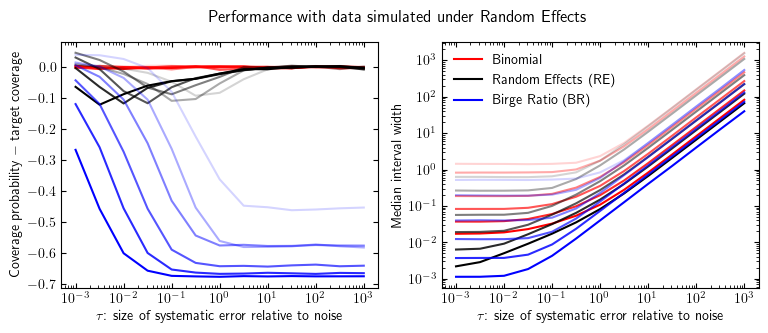

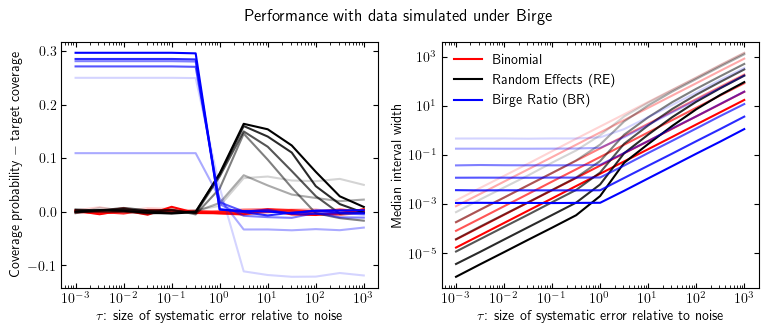

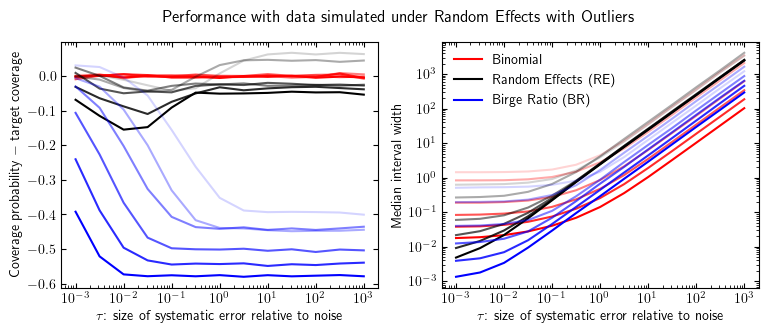

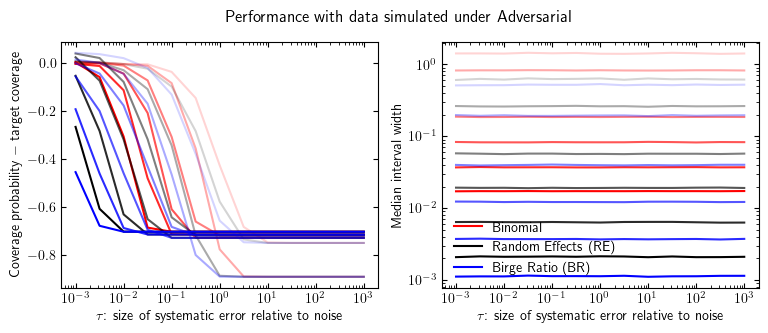

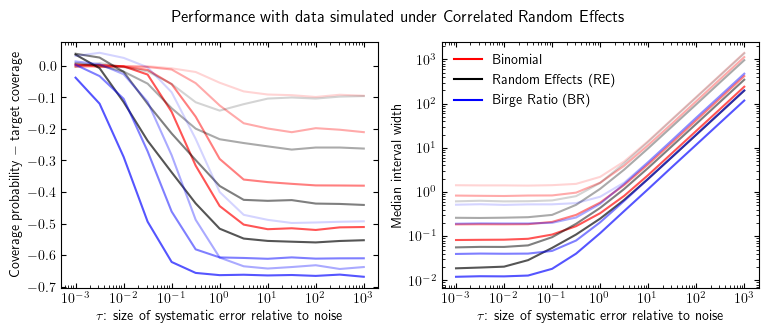

In [ ]:
colors = {"nonoise": "red", "re": "black", "birge": "blue"}
friendly_labels = {
    "nonoise": "Binomial",
    "re": "Random Effects (RE)",
    "birge": "Birge Ratio (BR)",
}
setting_labels = {
    "random_effects": "Random Effects",
    "birge": "Birge",
    "random_effects_outliers": "Random Effects with Outliers",
    "adversarial": "Adversarial",
    "random_effects_corr": "Correlated Random Effects",
}
print(target_coverages)
for setting in settings:
    fig, axs = plt.subplots(1, 2, figsize=(9, 3.2))
    for method in ["nonoise", "re", "birge"]:
        for i, n in enumerate(ns):
            if results[setting][(n, mus[0])] == {}:
                continue
            alpha = (i + 1) / len(ns)
            target_coverage = target_coverages[n]
            data = [results[setting][(n, mu)][f"coverage_{method}"] for mu in mus]
            data = np.array(data) - target_coverage
            if i == len(ns) - 1:
                label = friendly_labels[method]
            else:
                label = None
            axs[0].plot(mus, data, color=colors[method], label=label, alpha=alpha)
            data = [results[setting][(n, mu)][f"length_{method}"] for mu in mus]
            axs[1].plot(mus, data, color=colors[method], label=label, alpha=alpha)
    # log x scale on both axes
    axs[0].set_xscale("log")
    axs[1].set_xscale("log")
    # add top and right ticks
    for ax in axs:
        ax.yaxis.set_ticks_position("both")
        ax.xaxis.set_ticks_position("both")
        # ax.tick_params(direction='in')
        ax.tick_params(which="both", direction="in")

    # log y scale on right axis
    axs[1].set_yscale("log")

    # add legend with colors and corresponding labels
    plt.legend(frameon=False)

    axs[0].set_xlabel(r"$\tau$: size of systematic error relative to noise")
    axs[1].set_xlabel(r"$\tau$: size of systematic error relative to noise")
    axs[0].set_ylabel("Coverage probability $-$ target coverage")
    axs[1].set_ylabel("Median interval width")
    plt.suptitle(f"Performance with data simulated under {setting_labels[setting]}")
    plt.savefig(f"figs/performance_{setting}.pdf", bbox_inches="tight")
    plt.show()